## Image captioning using attention

https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/
https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch/

Flickr dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

In [5]:
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
from collections import Counter

from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


We are extracting the zipped image and caption files

In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/flickr_dataset/flickr8k.zip') as z:
    z.extractall()

!ls

captions.txt  drive  images  sample_data


In [7]:
!ls /content/images | wc -l

8091


In [8]:
image_captions = pd.read_csv('/content/captions.txt')

image_captions.sample(5)

,image,caption
29346,3482668767_66004ce736.jpg,a group of children sticking their own faces t...
17418,2944836001_b38b516286.jpg,Man holding a ball while a dog jumps up for it
9925,2466171114_3fa51415a7.jpg,A brown and white dog fetching a toy .
10494,2502935765_a0ae1fa7be.jpg,A little boy sits and spins on a playground .
5443,2144846312_d4c738dc6c.jpg,The baby is wearing a bib and sitting in an ad...


In [9]:
image_captions.shape

(40455, 2)

Device is defined for acceleration of training

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

Loading tokeniser from torchtext library and counter is instantiated

In [12]:
tokenizer = get_tokenizer('basic_english')

counter = Counter()

In [13]:
tokenizer('A horse and dog look at each other in a field .')

['a',
 'horse',
 'and',
 'dog',
 'look',
 'at',
 'each',
 'other',
 'in',
 'a',
 'field',
 '.']

We are building the vocabulary for captions using torchtext.

In [14]:
for line in image_captions['caption'].tolist():
    counter.update(tokenizer(line))

vocab = vocab(counter, min_freq = 5)

Special tokens are added and default index is set as UNK(Note that torchtext version in colab is 0.11.In latest version(0.12) we can simply add special tokens in vocab arguments itself)

In [15]:
unk_token = '<unk>'
pad_token = '<pad>'
sos_token = '<sos>'
eos_token = '<eos>'

vocab.insert_token(unk_token, 0)
vocab.insert_token(pad_token, 1)
vocab.insert_token(sos_token, 2)
vocab.insert_token(eos_token, 3)

vocab.set_default_index(vocab['<unk>'])

Dataset is defined and get_item method returns Images with their  captions tokens in integer form(token ids)

In [16]:
class FlickrDataset(Dataset):
   
    def __init__(self, root_dir, captions_file, vocab, transform = None):

        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab               
        
        df = pd.read_csv(captions_file)

        self.length = len(df)

        self.captions = df['caption']
        self.img_names = df['image']
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        caption_text_to_index = lambda x: [self.vocab[token] for token in tokenizer(x)]

        caption_vec = []
        caption_vec += [vocab['<sos>']]
        caption_vec +=  caption_text_to_index(caption)
        caption_vec += [vocab['<eos>']]
        
        return img, torch.tensor(caption_vec)

Data collation in the form of batches is defined with required padded sequences for captions

In [17]:
class generate_batch_captions:
  
    def __init__(self, pad_idx, batch_first = False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self, batch):

        # Each batch (image_tensor, caption_tensor)

        # image_tensor = [batch_size, num_channels, height, width]
        # caption_tensor = [batch_size, num_words_in_caption]

        # Add an extra dimension of size 1 at index 0
        # [num_channels, height, width] -> [1, num_channels, height, width]
        imgs = [item[0].unsqueeze(0) for item in batch]

        imgs = torch.cat(imgs, dim = 0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = self.batch_first, padding_value = self.pad_idx)
        
        return imgs, targets

In [18]:
def display_image(inp_img, title = 'Image'):
   
    inp_img[0] = inp_img[0] * 0.229
    inp_img[1] = inp_img[1] * 0.224 
    inp_img[2] = inp_img[2] * 0.225 

    inp_img[0] += 0.485 
    inp_img[1] += 0.456 
    inp_img[2] += 0.406

    inp_img = inp_img.numpy().transpose((1, 2, 0))
    plt.imshow(inp_img)
    plt.title(title)

    plt.pause(0.001)

Helper function to plot the image. Note that images are unnormalised

Transformation for image is defined.After resizing ,random cropping,conversion to tensor, Normalisation is done and one random image is shown with captions and their  token ids

In [19]:
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


flickr_dataset =  FlickrDataset(
    root_dir = '/content/images',
    captions_file = '/content/captions.txt',
    vocab = vocab,
    transform = transforms
)

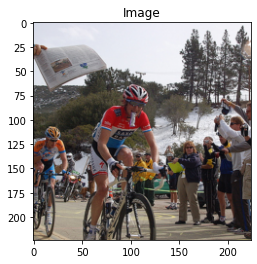

Token_ids: tensor([  2, 188,  39, 777, 595, 118,   4, 187,  13, 730,  17,   3])
Caption :
['<sos>', 'people', 'on', 'bicycles', 'riding', 'through', 'a', 'group', 'of', 'onlookers', '.', '<eos>']


In [20]:
img, ids = flickr_dataset[24908]
display_image(img)
print('Token_ids:', ids)
print('Caption :')
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

Dataloader is defined for the Dataset

In [21]:
batch_size = 128

pad_idx = vocab['<pad>']

data_loader = DataLoader(
    dataset =  flickr_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = generate_batch_captions(pad_idx = pad_idx, batch_first = True)
)

In [ ]:
resnet = models.resnet50()

print(resnet)

 Defining the Model Architecture.
 Ref. Notebook-
 https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch
 
 Model Architecture images can be viewed here-
 https://medium.com/analytics-vidhya/image-captioning-with-attention-part-1-e8a5f783f6d3

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder.

In [45]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        # Generates features of the shape [batch_size, 2048, 7, 7]
        # The output of the last layer of resnet produces 7x7 feature maps
        # image_size / 32 = 224 / 32 = 7
        features = self.resnet(images)

        batch, feature_maps, size_1, size_2 = features.size()

        # [batch_size, 2048, 7, 7] -> [batch_size, 7, 7, 2048]
        features = features.permute(0, 2, 3, 1)

        # [batch_size, 7, 7, 2048] -> [batch_size, 49, 2048]
        features = features.view(batch, -1, feature_maps)
       
        return features 

Attention network is defined

In [63]:
class Attention(nn.Module):

    def __init__(self,  enc_hidden_size, dec_hidden_size, attn_size):
        super(Attention, self).__init__()
        
        self.attn_size = attn_size
        
        self.enc_U = nn.Linear(enc_hidden_size, attn_size)
        self.dec_W = nn.Linear(dec_hidden_size, attn_size)
        
        self.full_A = nn.Linear(attn_size, 1)
        
    def forward(self, features, decoder_hidden_state):
        # [batch_size, dec_hidden_size] -> [batch_size, 1, dec_hidden_size]
        decoder_hidden_state = decoder_hidden_state.unsqueeze(1)

        # [batch_size, 49, 2048] -> [batch_size, 49, attn_size]
        enc_att = self.enc_U(features)     

        # [batch_size, 1, dec_hidden_size] -> [batch_size, 1, attn_size]
        dec_att = self.dec_W(decoder_hidden_state) 
        
        # [batch_size, 49, attn_size]
        combined_states = torch.tanh(enc_att + dec_att)

        # attn_scores shape [batch_size, 49, 1]
        attn_scores = self.full_A(combined_states)
 
        # [batch_size, 49, 1] -> [batch_size, 49]
        attn_scores = attn_scores.squeeze(2) 

        # attn_weight shape [batch_size, 49]
        attn_weight = F.softmax(attn_scores, dim = 1) 

        # context shape [batch_size, 248] -> 
        #               [batch_size, 49] * [batch_size, 49, 2048]
        # Context has same dimensions as the encoding output i.e. the
        # encoding_hidden_size 
        context = torch.sum(attn_weight.unsqueeze(2) * features,  dim = 1)
             
        return attn_weight, context
        

In [89]:
class DecoderRNN(nn.Module):

    def __init__(self, emb_size, vocab_size, attn_size, 
                       enc_hidden_size, dec_hidden_size, 
                       drop_prob = 0.3):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.attn_size = attn_size
        self.dec_hidden_size = dec_hidden_size
        
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.attn = Attention(enc_hidden_size, dec_hidden_size, attn_size)

        self.init_h = nn.Linear(enc_hidden_size, dec_hidden_size)  
        self.init_c = nn.Linear(enc_hidden_size, dec_hidden_size)  

        self.lstm_cell = nn.LSTMCell(emb_size + enc_hidden_size, dec_hidden_size, bias = True)
        
        self.fcn = nn.Linear(dec_hidden_size, vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    
    def forward(self, features, captions):
        # Captions shape [batch_size, longest_text_in_batch]
        # Embeddings shape [batch_size, longest_text_in_batch, embed_size] 
        # each word is represented using embedding of embed_size
        embeds = self.embedding(captions)

        # [batch_size, dec_hidden_size]        
        h, c = self.init_hidden_state(features) 
        
        seq_len = len(captions[0]) - 1 
        batch_size = captions.size(0)

        # Features shape: [batch_size, 49, 2048]
        num_features = features.size(1)
        
        # One-hot word predictions
        preds = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)

        # Initial attention weights for each time instance (each word)
        attn_weights = torch.zeros(batch_size, seq_len, num_features).to(device)
                
        for t in range(seq_len):
            attn_weight, context = self.attn(features, h)

            lstm_input = torch.cat((embeds[:, t], context), dim = 1)

            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:, t] = output
            attn_weights[:, t] = attn_weight 
        
        
        return preds, attn_weights
    
    def generate_caption(self, features, max_len = 20, vocab = None):
       
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  
        
        attn_weights = []
        
        word = torch.tensor(vocab['<sos>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        captions = []
        
        for i in range(max_len):

            attn_weight, context = self.attn(features, h)
            attn_weights.append(attn_weight.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim = 1)

            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)
            
            predicted_word_idx = output.argmax(dim = 1)
            
            captions.append(predicted_word_idx.item())
            
            if vocab.get_itos()[predicted_word_idx.item()] == '<eos>':
                break
            
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        return [vocab.get_itos()[idx] for idx in captions], attn_weights
    
    
    def init_hidden_state(self, features):
        mean_features = torch.mean(features, dim = 1)

        h = self.init_h(mean_features)  
        c = self.init_c(mean_features)

        return h, c


Image to Captions model is defined with both encoder and decoder(With Attention)

In [91]:
class Img2Captions(nn.Module):
    def __init__(self, emb_size, vocab_size, attn_size, 
                       enc_hidden_size, dec_hidden_size, drop_prob = 0.3):
        super().__init__()

        self.encoder = EncoderCNN()

        self.decoder = DecoderRNN(
            emb_size = emb_size,
            vocab_size = len(flickr_dataset.vocab),
            attn_size = attn_size,
            enc_hidden_size = enc_hidden_size,
            dec_hidden_size =  dec_hidden_size
        )
        
    def forward(self, images, captions):

        features = self.encoder(images)
        outputs = self.decoder(features, captions)

        return outputs


 Setting Hyperparameters for the model 

In [92]:
vocab_size = len(flickr_dataset.vocab)

emb_size = 300
attn_size = 256

enc_hidden_size = 2048
dec_hidden_size = 512

learning_rate = 3e-4

Model is instantiatied with the hyperparameters. Also, Loss function and optimizers are defined.

In [93]:
model = Img2Captions(
    emb_size,
    vocab_size,
    attn_size,
    enc_hidden_size,
    dec_hidden_size 
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Function for saving the Model is defined

In [94]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs': num_epochs,
        'emb_size': emb_size,
        'vocab_size': len(flickr_dataset.vocab),
        'attn_size': attn_size,
        'enc_hidden_size': enc_hidden_size,
        'dec_hidden_size': dec_hidden_size,
        'state_dict': model.state_dict()
    }

    torch.save(model_state, 'attention_model_state.pth')

Training is started with Model evaluation done at every 100 steps with Images with their predicted captions displayed.

Epoch: 1 loss: 4.25879


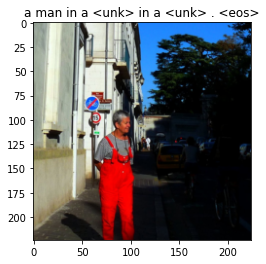

Epoch: 1 loss: 3.66202


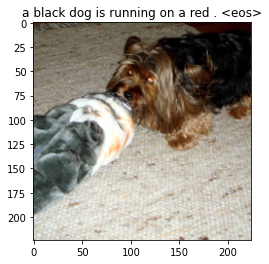

Epoch: 1 loss: 3.52320


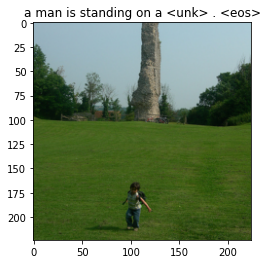

Epoch: 2 loss: 3.37154


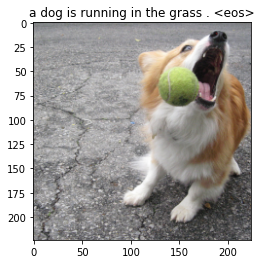

Epoch: 2 loss: 3.04278


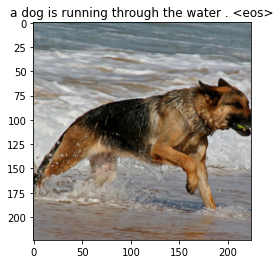

Epoch: 2 loss: 3.25204


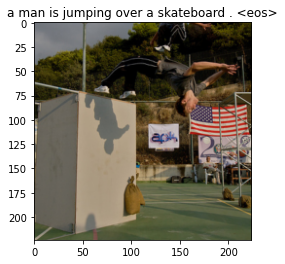

Epoch: 3 loss: 2.91134


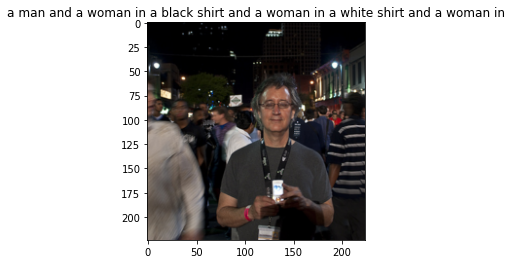

Epoch: 3 loss: 2.73570


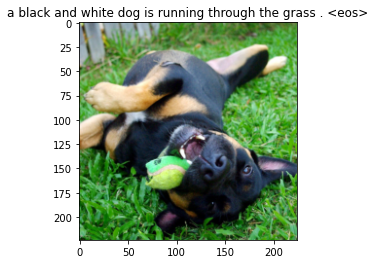

Epoch: 3 loss: 2.85205


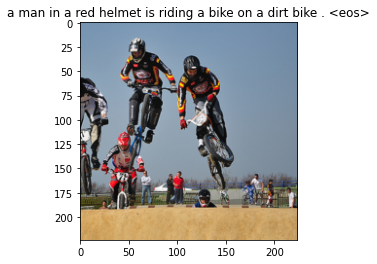

Epoch: 4 loss: 2.76538


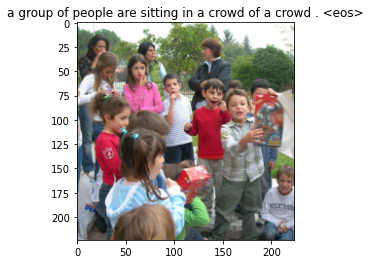

Epoch: 4 loss: 2.69637


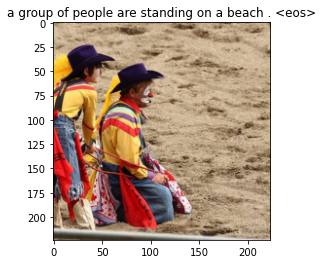

Epoch: 4 loss: 2.68594


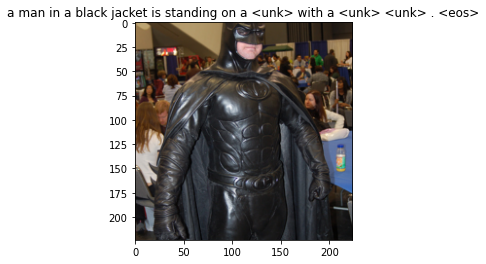

Epoch: 5 loss: 2.56545


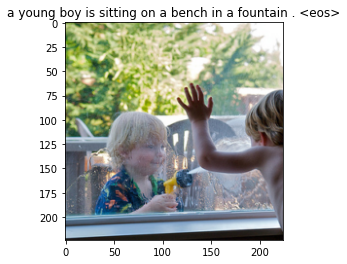

KeyboardInterrupt: ignored

In [95]:
num_epochs = 10
print_every = 100

for epoch in range(1, num_epochs + 1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):

        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()

        outputs, attentions = model(image, captions)

        targets = captions[:, 1:]

        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        loss.backward()
        optimizer.step()

        if (idx + 1) % print_every == 0:
            print('Epoch: {} loss: {:.5f}'.format(epoch,loss.item()))

            model.eval()
            with torch.no_grad():
                img, _ = next(iter(data_loader))

                features = model.encoder(img[0:1].to(device))
                caps, attn_weights = model.decoder.generate_caption(features, vocab = flickr_dataset.vocab)

                caption = ' '.join(caps)
                display_image(img[0], title = caption)
                
            model.train()
    
    save_model(model, epoch)

For visualising attentions following helper functions are defined.
generate_caps-Given the image generate captions and attention scores
show_attention-Plot the attention scores in the image

In [96]:
def generate_caps(features_tensors):
    model.eval()

    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, attn_weight = model.decoder.generate_caption(features, vocab = flickr_dataset.vocab)

        caption = ' '.join(caps)
        display_image(features_tensors[0])
    
    return caps, attn_weight

def show_attention(img, result, attention_plot):
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize = (15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7, 7)
        
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap = 'gray', alpha = 0.7, extent = img.get_extent())
        

    plt.tight_layout()
    plt.show()

Attention maps are displayed for few images

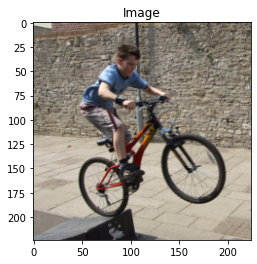

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

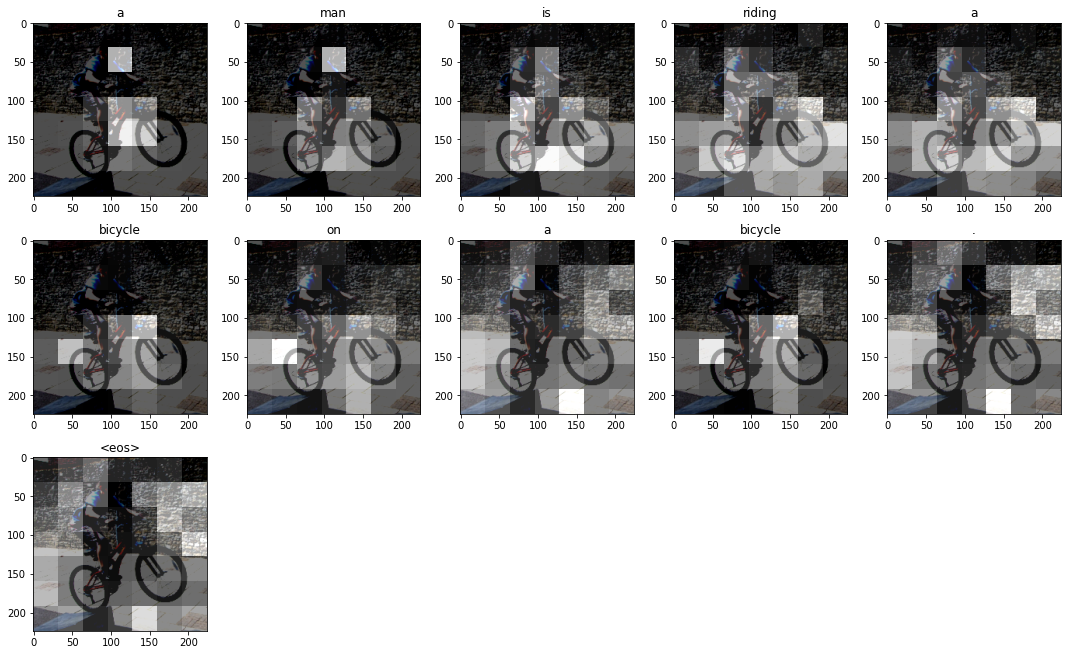

In [97]:
images, _ = next(iter(data_loader))

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, attn_weight = generate_caps(img.unsqueeze(0))

show_attention(img1, caps, attn_weight)

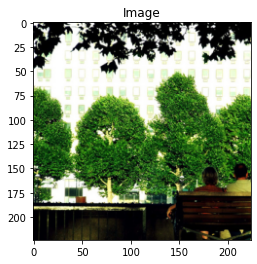

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

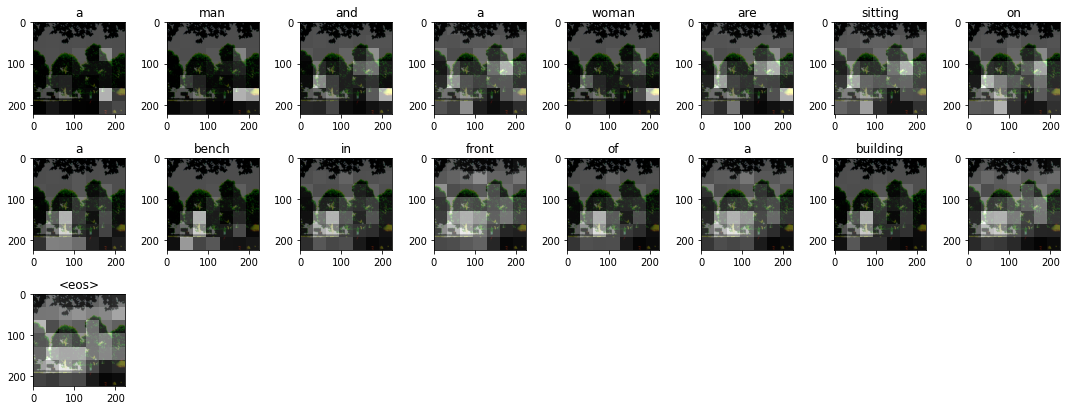

In [98]:
images, _ = next(iter(data_loader))

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, attn_weight = generate_caps(img.unsqueeze(0))

show_attention(img1, caps, attn_weight)

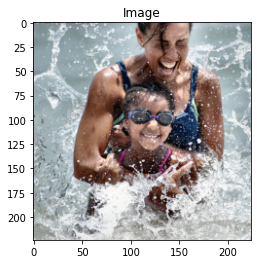

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


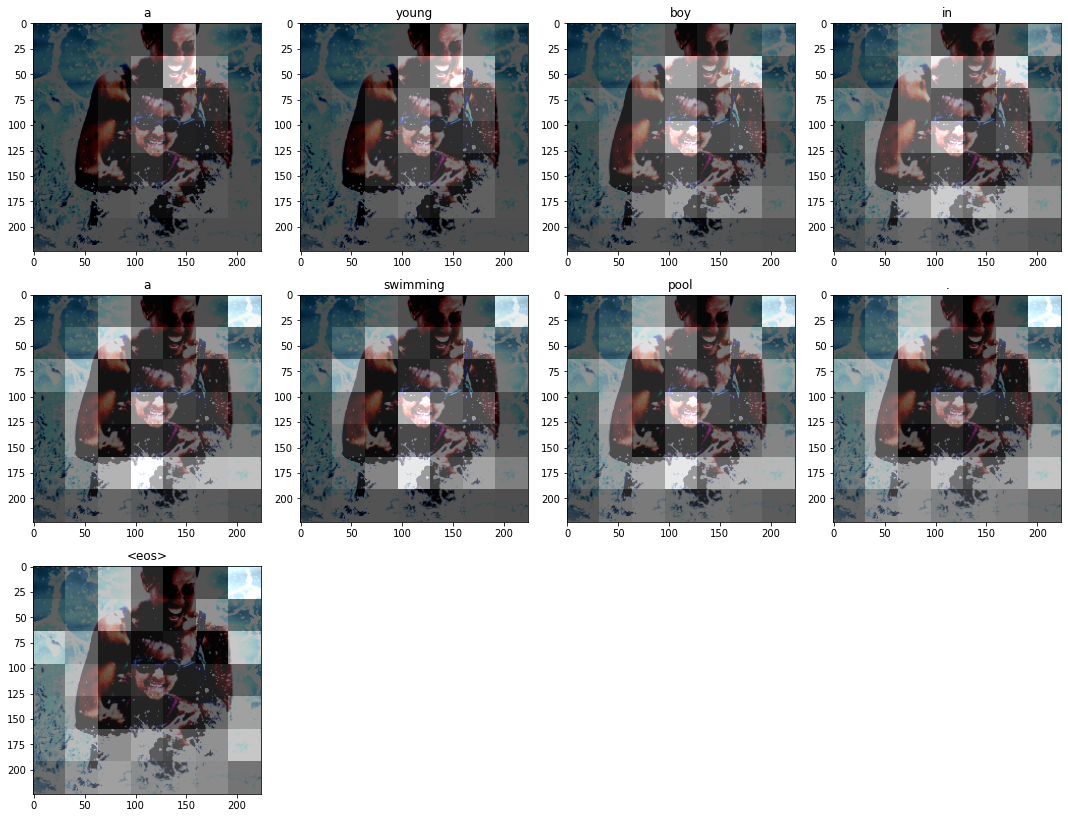

In [99]:
images, _ = next(iter(data_loader))

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, attn_weight = generate_caps(img.unsqueeze(0))

show_attention(img1, caps, attn_weight)

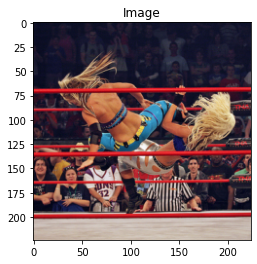

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

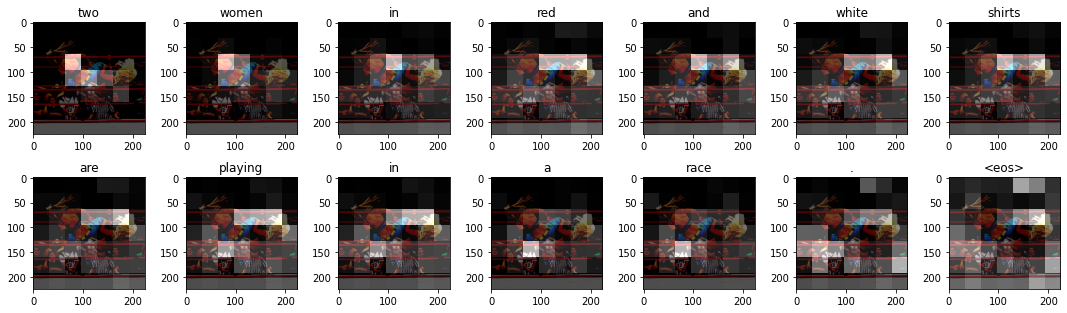

In [100]:
images, _ = next(iter(data_loader))

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, attn_weight = generate_caps(img.unsqueeze(0))

show_attention(img1, caps, attn_weight)